# Chapter 4: Acceralation of word2vec

The problem of word2vec which implemented previous chapter is that it would be slow if the courpus is huge. So, we need to improve word2vec.

## 4.1 word2vec improvement : Embedding class

forward method of Embedding class just extract the word vector which associated  with current id from the weight matrix.


In [1]:
import numpy as np

W = np.arange(21).reshape(7, 3)

print(W)
print(W[2])

idx = np.array([1, 0, 2])
print(idx)
print(W[idx])

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]
[6 7 8]
[1 0 2]
[[3 4 5]
 [0 1 2]
 [6 7 8]]


In [13]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        # np.add.at(dW, self.idx, dout)
        # return None
        for i, word_id in enumerate(self.idx):
            dW[word_id] += dout[i]
        return None

In [5]:
tdW = np.random.randn(7, 3)

print(tdW)

tdW[...] = 0

print(tdW)

[[ 0.49946842  0.8489738   2.1829028 ]
 [ 0.09960695  0.52036084 -0.02493133]
 [ 0.23603348 -0.20604174  0.03029815]
 [-0.59506454 -0.07256343  0.13132624]
 [-0.12602725 -0.24052616  0.39472937]
 [-3.49503328  0.74784748  0.17114258]
 [ 0.17899334 -0.12349312 -0.89240249]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


## 4.2 word2vec improvement : Negative sampling

### 4.2.1 calculation problem after middle layer

When the corpus size is huge, calculation takes time in following process.

- the product of the neurons of the hidden layer and the weight matrix
- calculation of Softmax layer

For example, softmax is shown as following assuming that the corpus size is 100,000.

$$
y = \frac{\exp(x_i)}{\sum_j^{1000000} \exp(x_j)}
$$

### 4.2.2 Negative sampling

To reduce the calculation problem, we use negative sampling in which we randomly select negative samples from the corpus.

### 4.2.3 Sigmoid function and Cross entropy error

Sigmoid function and Cross entropy error are shown as following.

Sigmoid:
$$
y = \frac{1}{1 + e^{-x}}
$$

Cross entropy error:
$$
L = -(t \log y + (1 - t) \log (1 - y))
$$

![../images/4.2.3.png](./fig/4_2_3.drawio.svg)

### 4.2.4 From multiclass classification to binary classification

Here is a diagram of the CBOW (Continuous Bag of Words) model for multi-class classification:
![img](./fig/4_2_4.drawio.svg)

In order to reduce the calculation problem, we use CBOW model for binary classification as shown below:
![img](./fig/4_2_4_2.drawio.svg)


In [11]:
# embedding dot class
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

In [7]:
import numpy as np
W = np.arange(21).reshape(7, 3)
h = np.arange(9).reshape(3, 3)
idx = np.array([0, 3, 1])

embed = Embedding(W)
target_W = embed.forward(idx)
out = np.sum(target_W * h, axis=1)

print(out.reshape(out.shape[0], 1))
print(target_W)
print(h)

[[  5]
 [122]
 [ 86]]
[[ 0  1  2]
 [ 9 10 11]
 [ 3  4  5]]
[[0 1 2]
 [3 4 5]
 [6 7 8]]


### 4.2.5 Negative sampling

Negative sampling is learning correct words with some sample incorrect words.
Normally 5 ~ 10 negtive samples are randomly selected from the corpus.
This is the reason to be called Negative sampling.

### 4.2.6 Sampling method of Negative sampling

when we use negative sampling, we use appearance probability of the word in the corpus.

$$
P'(W_i) = \frac{P(W_i)^{0.75}}{\sum_j^{n} P(W_j)^{0.75}}
$$

In [8]:
import numpy as np

np.random.choice(10)

words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
print(np.random.choice(words))
print(np.random.choice(words))

print(np.random.choice(words, size=3))
print(np.random.choice(words, size=3, replace=False))

# use probability
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
print(np.random.choice(words, p=p))
print(np.random.choice(words, p=p))
print(np.random.choice(words, p=p))
print(np.random.choice(words, p=p))
print(np.random.choice(words, p=p))

p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p)

say
hello
['.' 'I' 'goodbye']
['hello' 'say' 'I']
.
.
you
.
you
[0.64196878 0.33150408 0.02652714]


In [9]:
# 4.2.6 Negative sampling
GPU = False

import collections

class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

In [10]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
counts = collections.Counter()

for word_id in corpus:
    counts[word_id] += 1

In [11]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)

print(negative_sample)


[[2 4]
 [0 2]
 [1 3]]


### 4.2.7 Implementation of Negative sampling

In [8]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx

In [6]:
# Class NegativeSamplingLoss
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 1.正例の評価
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 2.負例の評価
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
            
        return dh




## 4.3 Learning of improved word2vec

### 4.3.1 implementation of CBOW model


In [2]:
import sys
import numpy as np

class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            self.word_vecs = W_in
    
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None


### 4.3.2 Learning of CBOW


| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 0[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 1[s] | loss 4.12
| epoch 1 |  iter 81 / 9295 | time 1[s] | loss 4.05
| epoch 1 |  iter 101 / 9295 | time 2[s] | loss 3.92
| epoch 1 |  iter 121 / 9295 | time 2[s] | loss 3.77
| epoch 1 |  iter 141 / 9295 | time 3[s] | loss 3.63
| epoch 1 |  iter 161 / 9295 | time 3[s] | loss 3.49
| epoch 1 |  iter 181 / 9295 | time 4[s] | loss 3.36
| epoch 1 |  iter 201 / 9295 | time 4[s] | loss 3.25
| epoch 1 |  iter 221 / 9295 | time 4[s] | loss 3.16
| epoch 1 |  iter 241 / 9295 | time 5[s] | loss 3.08
| epoch 1 |  iter 261 / 9295 | time 5[s] | loss 3.02
| epoch 1 |  iter 281 / 9295 | time 6[s] | loss 2.97
| epoch 1 |  iter 301 / 9295 | time 6[s] | loss 2.91
| epoch 1 |  iter 321 / 9295 | time 7[s] | loss 2.88
| epoch 1 |  iter 341 / 9295 | time 7[s] | loss 2.83
| epoch 1 |  iter 361 / 9295 | time 7[s] | loss 2.81

| epoch 1 |  iter 3021 / 9295 | time 65[s] | loss 2.44
| epoch 1 |  iter 3041 / 9295 | time 66[s] | loss 2.45
| epoch 1 |  iter 3061 / 9295 | time 66[s] | loss 2.44
| epoch 1 |  iter 3081 / 9295 | time 67[s] | loss 2.44
| epoch 1 |  iter 3101 / 9295 | time 67[s] | loss 2.43
| epoch 1 |  iter 3121 / 9295 | time 68[s] | loss 2.42
| epoch 1 |  iter 3141 / 9295 | time 68[s] | loss 2.43
| epoch 1 |  iter 3161 / 9295 | time 69[s] | loss 2.42
| epoch 1 |  iter 3181 / 9295 | time 69[s] | loss 2.44
| epoch 1 |  iter 3201 / 9295 | time 70[s] | loss 2.46
| epoch 1 |  iter 3221 / 9295 | time 70[s] | loss 2.45
| epoch 1 |  iter 3241 / 9295 | time 70[s] | loss 2.45
| epoch 1 |  iter 3261 / 9295 | time 71[s] | loss 2.48
| epoch 1 |  iter 3281 / 9295 | time 71[s] | loss 2.42
| epoch 1 |  iter 3301 / 9295 | time 72[s] | loss 2.43
| epoch 1 |  iter 3321 / 9295 | time 72[s] | loss 2.41
| epoch 1 |  iter 3341 / 9295 | time 73[s] | loss 2.44
| epoch 1 |  iter 3361 / 9295 | time 73[s] | loss 2.44
| epoch 1 

| epoch 1 |  iter 5981 / 9295 | time 129[s] | loss 2.34
| epoch 1 |  iter 6001 / 9295 | time 130[s] | loss 2.30
| epoch 1 |  iter 6021 / 9295 | time 130[s] | loss 2.37
| epoch 1 |  iter 6041 / 9295 | time 131[s] | loss 2.33
| epoch 1 |  iter 6061 / 9295 | time 131[s] | loss 2.34
| epoch 1 |  iter 6081 / 9295 | time 131[s] | loss 2.32
| epoch 1 |  iter 6101 / 9295 | time 132[s] | loss 2.33
| epoch 1 |  iter 6121 / 9295 | time 132[s] | loss 2.30
| epoch 1 |  iter 6141 / 9295 | time 133[s] | loss 2.30
| epoch 1 |  iter 6161 / 9295 | time 133[s] | loss 2.30
| epoch 1 |  iter 6181 / 9295 | time 134[s] | loss 2.29
| epoch 1 |  iter 6201 / 9295 | time 134[s] | loss 2.30
| epoch 1 |  iter 6221 / 9295 | time 134[s] | loss 2.31
| epoch 1 |  iter 6241 / 9295 | time 135[s] | loss 2.32
| epoch 1 |  iter 6261 / 9295 | time 135[s] | loss 2.34
| epoch 1 |  iter 6281 / 9295 | time 136[s] | loss 2.28
| epoch 1 |  iter 6301 / 9295 | time 136[s] | loss 2.31
| epoch 1 |  iter 6321 / 9295 | time 137[s] | lo

| epoch 1 |  iter 8921 / 9295 | time 193[s] | loss 2.23
| epoch 1 |  iter 8941 / 9295 | time 194[s] | loss 2.24
| epoch 1 |  iter 8961 / 9295 | time 194[s] | loss 2.27
| epoch 1 |  iter 8981 / 9295 | time 195[s] | loss 2.22
| epoch 1 |  iter 9001 / 9295 | time 195[s] | loss 2.21
| epoch 1 |  iter 9021 / 9295 | time 196[s] | loss 2.21
| epoch 1 |  iter 9041 / 9295 | time 196[s] | loss 2.21
| epoch 1 |  iter 9061 / 9295 | time 197[s] | loss 2.20
| epoch 1 |  iter 9081 / 9295 | time 197[s] | loss 2.23
| epoch 1 |  iter 9101 / 9295 | time 198[s] | loss 2.17
| epoch 1 |  iter 9121 / 9295 | time 198[s] | loss 2.18
| epoch 1 |  iter 9141 / 9295 | time 199[s] | loss 2.22
| epoch 1 |  iter 9161 / 9295 | time 199[s] | loss 2.22
| epoch 1 |  iter 9181 / 9295 | time 200[s] | loss 2.22
| epoch 1 |  iter 9201 / 9295 | time 200[s] | loss 2.24
| epoch 1 |  iter 9221 / 9295 | time 200[s] | loss 2.24
| epoch 1 |  iter 9241 / 9295 | time 201[s] | loss 2.21
| epoch 1 |  iter 9261 / 9295 | time 201[s] | lo

| epoch 2 |  iter 2581 / 9295 | time 258[s] | loss 2.12
| epoch 2 |  iter 2601 / 9295 | time 258[s] | loss 2.16
| epoch 2 |  iter 2621 / 9295 | time 258[s] | loss 2.13
| epoch 2 |  iter 2641 / 9295 | time 259[s] | loss 2.11
| epoch 2 |  iter 2661 / 9295 | time 259[s] | loss 2.08
| epoch 2 |  iter 2681 / 9295 | time 260[s] | loss 2.12
| epoch 2 |  iter 2701 / 9295 | time 260[s] | loss 2.13
| epoch 2 |  iter 2721 / 9295 | time 261[s] | loss 2.13
| epoch 2 |  iter 2741 / 9295 | time 261[s] | loss 2.13
| epoch 2 |  iter 2761 / 9295 | time 261[s] | loss 2.11
| epoch 2 |  iter 2781 / 9295 | time 262[s] | loss 2.16
| epoch 2 |  iter 2801 / 9295 | time 262[s] | loss 2.11
| epoch 2 |  iter 2821 / 9295 | time 263[s] | loss 2.10
| epoch 2 |  iter 2841 / 9295 | time 263[s] | loss 2.12
| epoch 2 |  iter 2861 / 9295 | time 264[s] | loss 2.16
| epoch 2 |  iter 2881 / 9295 | time 264[s] | loss 2.14
| epoch 2 |  iter 2901 / 9295 | time 264[s] | loss 2.11
| epoch 2 |  iter 2921 / 9295 | time 265[s] | lo

| epoch 2 |  iter 5521 / 9295 | time 324[s] | loss 2.08
| epoch 2 |  iter 5541 / 9295 | time 325[s] | loss 2.08
| epoch 2 |  iter 5561 / 9295 | time 325[s] | loss 2.07
| epoch 2 |  iter 5581 / 9295 | time 325[s] | loss 2.07
| epoch 2 |  iter 5601 / 9295 | time 326[s] | loss 2.09
| epoch 2 |  iter 5621 / 9295 | time 326[s] | loss 2.07
| epoch 2 |  iter 5641 / 9295 | time 327[s] | loss 2.10
| epoch 2 |  iter 5661 / 9295 | time 327[s] | loss 2.04
| epoch 2 |  iter 5681 / 9295 | time 328[s] | loss 2.11
| epoch 2 |  iter 5701 / 9295 | time 328[s] | loss 2.06
| epoch 2 |  iter 5721 / 9295 | time 329[s] | loss 2.10
| epoch 2 |  iter 5741 / 9295 | time 329[s] | loss 2.02
| epoch 2 |  iter 5761 / 9295 | time 329[s] | loss 2.06
| epoch 2 |  iter 5781 / 9295 | time 330[s] | loss 2.09
| epoch 2 |  iter 5801 / 9295 | time 330[s] | loss 2.07
| epoch 2 |  iter 5821 / 9295 | time 331[s] | loss 2.04
| epoch 2 |  iter 5841 / 9295 | time 331[s] | loss 2.05
| epoch 2 |  iter 5861 / 9295 | time 332[s] | lo

| epoch 2 |  iter 8461 / 9295 | time 388[s] | loss 2.03
| epoch 2 |  iter 8481 / 9295 | time 389[s] | loss 2.03
| epoch 2 |  iter 8501 / 9295 | time 389[s] | loss 2.06
| epoch 2 |  iter 8521 / 9295 | time 390[s] | loss 2.00
| epoch 2 |  iter 8541 / 9295 | time 390[s] | loss 2.00
| epoch 2 |  iter 8561 / 9295 | time 390[s] | loss 1.97
| epoch 2 |  iter 8581 / 9295 | time 391[s] | loss 2.00
| epoch 2 |  iter 8601 / 9295 | time 391[s] | loss 2.03
| epoch 2 |  iter 8621 / 9295 | time 392[s] | loss 2.03
| epoch 2 |  iter 8641 / 9295 | time 392[s] | loss 1.99
| epoch 2 |  iter 8661 / 9295 | time 393[s] | loss 2.02
| epoch 2 |  iter 8681 / 9295 | time 393[s] | loss 2.02
| epoch 2 |  iter 8701 / 9295 | time 394[s] | loss 2.01
| epoch 2 |  iter 8721 / 9295 | time 394[s] | loss 2.05
| epoch 2 |  iter 8741 / 9295 | time 394[s] | loss 2.02
| epoch 2 |  iter 8761 / 9295 | time 395[s] | loss 2.01
| epoch 2 |  iter 8781 / 9295 | time 395[s] | loss 2.01
| epoch 2 |  iter 8801 / 9295 | time 396[s] | lo

| epoch 3 |  iter 2121 / 9295 | time 455[s] | loss 1.92
| epoch 3 |  iter 2141 / 9295 | time 456[s] | loss 1.92
| epoch 3 |  iter 2161 / 9295 | time 456[s] | loss 1.93
| epoch 3 |  iter 2181 / 9295 | time 457[s] | loss 1.95
| epoch 3 |  iter 2201 / 9295 | time 457[s] | loss 1.95
| epoch 3 |  iter 2221 / 9295 | time 457[s] | loss 1.95
| epoch 3 |  iter 2241 / 9295 | time 458[s] | loss 1.94
| epoch 3 |  iter 2261 / 9295 | time 458[s] | loss 1.94
| epoch 3 |  iter 2281 / 9295 | time 459[s] | loss 1.93
| epoch 3 |  iter 2301 / 9295 | time 459[s] | loss 1.95
| epoch 3 |  iter 2321 / 9295 | time 460[s] | loss 1.95
| epoch 3 |  iter 2341 / 9295 | time 460[s] | loss 1.93
| epoch 3 |  iter 2361 / 9295 | time 461[s] | loss 1.95
| epoch 3 |  iter 2381 / 9295 | time 461[s] | loss 1.92
| epoch 3 |  iter 2401 / 9295 | time 461[s] | loss 1.97
| epoch 3 |  iter 2421 / 9295 | time 462[s] | loss 1.97
| epoch 3 |  iter 2441 / 9295 | time 462[s] | loss 1.93
| epoch 3 |  iter 2461 / 9295 | time 463[s] | lo

| epoch 3 |  iter 5061 / 9295 | time 522[s] | loss 1.96
| epoch 3 |  iter 5081 / 9295 | time 522[s] | loss 1.89
| epoch 3 |  iter 5101 / 9295 | time 523[s] | loss 1.96
| epoch 3 |  iter 5121 / 9295 | time 523[s] | loss 1.94
| epoch 3 |  iter 5141 / 9295 | time 523[s] | loss 1.92
| epoch 3 |  iter 5161 / 9295 | time 524[s] | loss 1.94
| epoch 3 |  iter 5181 / 9295 | time 524[s] | loss 1.91
| epoch 3 |  iter 5201 / 9295 | time 525[s] | loss 1.93
| epoch 3 |  iter 5221 / 9295 | time 525[s] | loss 1.93
| epoch 3 |  iter 5241 / 9295 | time 526[s] | loss 1.92
| epoch 3 |  iter 5261 / 9295 | time 526[s] | loss 1.93
| epoch 3 |  iter 5281 / 9295 | time 526[s] | loss 1.93
| epoch 3 |  iter 5301 / 9295 | time 527[s] | loss 1.93
| epoch 3 |  iter 5321 / 9295 | time 527[s] | loss 1.92
| epoch 3 |  iter 5341 / 9295 | time 528[s] | loss 1.87
| epoch 3 |  iter 5361 / 9295 | time 528[s] | loss 1.92
| epoch 3 |  iter 5381 / 9295 | time 529[s] | loss 1.93
| epoch 3 |  iter 5401 / 9295 | time 529[s] | lo

| epoch 3 |  iter 8001 / 9295 | time 587[s] | loss 1.89
| epoch 3 |  iter 8021 / 9295 | time 587[s] | loss 1.90
| epoch 3 |  iter 8041 / 9295 | time 588[s] | loss 1.89
| epoch 3 |  iter 8061 / 9295 | time 588[s] | loss 1.86
| epoch 3 |  iter 8081 / 9295 | time 589[s] | loss 1.88
| epoch 3 |  iter 8101 / 9295 | time 589[s] | loss 1.92
| epoch 3 |  iter 8121 / 9295 | time 590[s] | loss 1.91
| epoch 3 |  iter 8141 / 9295 | time 590[s] | loss 1.93
| epoch 3 |  iter 8161 / 9295 | time 591[s] | loss 1.88
| epoch 3 |  iter 8181 / 9295 | time 591[s] | loss 1.87
| epoch 3 |  iter 8201 / 9295 | time 592[s] | loss 1.87
| epoch 3 |  iter 8221 / 9295 | time 592[s] | loss 1.92
| epoch 3 |  iter 8241 / 9295 | time 592[s] | loss 1.85
| epoch 3 |  iter 8261 / 9295 | time 593[s] | loss 1.89
| epoch 3 |  iter 8281 / 9295 | time 593[s] | loss 1.87
| epoch 3 |  iter 8301 / 9295 | time 594[s] | loss 1.86
| epoch 3 |  iter 8321 / 9295 | time 594[s] | loss 1.88
| epoch 3 |  iter 8341 / 9295 | time 595[s] | lo

| epoch 4 |  iter 1661 / 9295 | time 652[s] | loss 1.81
| epoch 4 |  iter 1681 / 9295 | time 653[s] | loss 1.81
| epoch 4 |  iter 1701 / 9295 | time 653[s] | loss 1.80
| epoch 4 |  iter 1721 / 9295 | time 654[s] | loss 1.84
| epoch 4 |  iter 1741 / 9295 | time 654[s] | loss 1.79
| epoch 4 |  iter 1761 / 9295 | time 655[s] | loss 1.81
| epoch 4 |  iter 1781 / 9295 | time 655[s] | loss 1.83
| epoch 4 |  iter 1801 / 9295 | time 656[s] | loss 1.81
| epoch 4 |  iter 1821 / 9295 | time 656[s] | loss 1.82
| epoch 4 |  iter 1841 / 9295 | time 656[s] | loss 1.80
| epoch 4 |  iter 1861 / 9295 | time 657[s] | loss 1.81
| epoch 4 |  iter 1881 / 9295 | time 657[s] | loss 1.80
| epoch 4 |  iter 1901 / 9295 | time 658[s] | loss 1.82
| epoch 4 |  iter 1921 / 9295 | time 658[s] | loss 1.83
| epoch 4 |  iter 1941 / 9295 | time 659[s] | loss 1.85
| epoch 4 |  iter 1961 / 9295 | time 659[s] | loss 1.82
| epoch 4 |  iter 1981 / 9295 | time 660[s] | loss 1.85
| epoch 4 |  iter 2001 / 9295 | time 660[s] | lo

| epoch 4 |  iter 4601 / 9295 | time 717[s] | loss 1.79
| epoch 4 |  iter 4621 / 9295 | time 717[s] | loss 1.81
| epoch 4 |  iter 4641 / 9295 | time 717[s] | loss 1.84
| epoch 4 |  iter 4661 / 9295 | time 718[s] | loss 1.80
| epoch 4 |  iter 4681 / 9295 | time 718[s] | loss 1.78
| epoch 4 |  iter 4701 / 9295 | time 719[s] | loss 1.81
| epoch 4 |  iter 4721 / 9295 | time 719[s] | loss 1.82
| epoch 4 |  iter 4741 / 9295 | time 720[s] | loss 1.82
| epoch 4 |  iter 4761 / 9295 | time 720[s] | loss 1.81
| epoch 4 |  iter 4781 / 9295 | time 720[s] | loss 1.82
| epoch 4 |  iter 4801 / 9295 | time 721[s] | loss 1.80
| epoch 4 |  iter 4821 / 9295 | time 721[s] | loss 1.80
| epoch 4 |  iter 4841 / 9295 | time 722[s] | loss 1.83
| epoch 4 |  iter 4861 / 9295 | time 722[s] | loss 1.80
| epoch 4 |  iter 4881 / 9295 | time 723[s] | loss 1.85
| epoch 4 |  iter 4901 / 9295 | time 723[s] | loss 1.78
| epoch 4 |  iter 4921 / 9295 | time 723[s] | loss 1.80
| epoch 4 |  iter 4941 / 9295 | time 724[s] | lo

| epoch 4 |  iter 7541 / 9295 | time 780[s] | loss 1.81
| epoch 4 |  iter 7561 / 9295 | time 781[s] | loss 1.77
| epoch 4 |  iter 7581 / 9295 | time 781[s] | loss 1.78
| epoch 4 |  iter 7601 / 9295 | time 782[s] | loss 1.81
| epoch 4 |  iter 7621 / 9295 | time 782[s] | loss 1.79
| epoch 4 |  iter 7641 / 9295 | time 783[s] | loss 1.79
| epoch 4 |  iter 7661 / 9295 | time 783[s] | loss 1.83
| epoch 4 |  iter 7681 / 9295 | time 783[s] | loss 1.81
| epoch 4 |  iter 7701 / 9295 | time 784[s] | loss 1.80
| epoch 4 |  iter 7721 / 9295 | time 784[s] | loss 1.77
| epoch 4 |  iter 7741 / 9295 | time 785[s] | loss 1.82
| epoch 4 |  iter 7761 / 9295 | time 785[s] | loss 1.86
| epoch 4 |  iter 7781 / 9295 | time 786[s] | loss 1.77
| epoch 4 |  iter 7801 / 9295 | time 786[s] | loss 1.78
| epoch 4 |  iter 7821 / 9295 | time 786[s] | loss 1.80
| epoch 4 |  iter 7841 / 9295 | time 787[s] | loss 1.81
| epoch 4 |  iter 7861 / 9295 | time 787[s] | loss 1.86
| epoch 4 |  iter 7881 / 9295 | time 788[s] | lo

| epoch 5 |  iter 1201 / 9295 | time 845[s] | loss 1.74
| epoch 5 |  iter 1221 / 9295 | time 845[s] | loss 1.70
| epoch 5 |  iter 1241 / 9295 | time 846[s] | loss 1.68
| epoch 5 |  iter 1261 / 9295 | time 846[s] | loss 1.73
| epoch 5 |  iter 1281 / 9295 | time 847[s] | loss 1.75
| epoch 5 |  iter 1301 / 9295 | time 847[s] | loss 1.76
| epoch 5 |  iter 1321 / 9295 | time 848[s] | loss 1.75
| epoch 5 |  iter 1341 / 9295 | time 848[s] | loss 1.71
| epoch 5 |  iter 1361 / 9295 | time 849[s] | loss 1.72
| epoch 5 |  iter 1381 / 9295 | time 849[s] | loss 1.72
| epoch 5 |  iter 1401 / 9295 | time 849[s] | loss 1.71
| epoch 5 |  iter 1421 / 9295 | time 850[s] | loss 1.73
| epoch 5 |  iter 1441 / 9295 | time 850[s] | loss 1.72
| epoch 5 |  iter 1461 / 9295 | time 851[s] | loss 1.72
| epoch 5 |  iter 1481 / 9295 | time 851[s] | loss 1.71
| epoch 5 |  iter 1501 / 9295 | time 852[s] | loss 1.73
| epoch 5 |  iter 1521 / 9295 | time 852[s] | loss 1.76
| epoch 5 |  iter 1541 / 9295 | time 852[s] | lo

| epoch 5 |  iter 4141 / 9295 | time 909[s] | loss 1.77
| epoch 5 |  iter 4161 / 9295 | time 909[s] | loss 1.75
| epoch 5 |  iter 4181 / 9295 | time 909[s] | loss 1.68
| epoch 5 |  iter 4201 / 9295 | time 910[s] | loss 1.75
| epoch 5 |  iter 4221 / 9295 | time 910[s] | loss 1.76
| epoch 5 |  iter 4241 / 9295 | time 911[s] | loss 1.71
| epoch 5 |  iter 4261 / 9295 | time 911[s] | loss 1.75
| epoch 5 |  iter 4281 / 9295 | time 912[s] | loss 1.76
| epoch 5 |  iter 4301 / 9295 | time 912[s] | loss 1.75
| epoch 5 |  iter 4321 / 9295 | time 912[s] | loss 1.74
| epoch 5 |  iter 4341 / 9295 | time 913[s] | loss 1.74
| epoch 5 |  iter 4361 / 9295 | time 913[s] | loss 1.76
| epoch 5 |  iter 4381 / 9295 | time 914[s] | loss 1.73
| epoch 5 |  iter 4401 / 9295 | time 914[s] | loss 1.74
| epoch 5 |  iter 4421 / 9295 | time 915[s] | loss 1.73
| epoch 5 |  iter 4441 / 9295 | time 915[s] | loss 1.71
| epoch 5 |  iter 4461 / 9295 | time 915[s] | loss 1.71
| epoch 5 |  iter 4481 / 9295 | time 916[s] | lo

| epoch 5 |  iter 7081 / 9295 | time 971[s] | loss 1.76
| epoch 5 |  iter 7101 / 9295 | time 972[s] | loss 1.71
| epoch 5 |  iter 7121 / 9295 | time 972[s] | loss 1.75
| epoch 5 |  iter 7141 / 9295 | time 973[s] | loss 1.72
| epoch 5 |  iter 7161 / 9295 | time 973[s] | loss 1.73
| epoch 5 |  iter 7181 / 9295 | time 974[s] | loss 1.69
| epoch 5 |  iter 7201 / 9295 | time 974[s] | loss 1.76
| epoch 5 |  iter 7221 / 9295 | time 974[s] | loss 1.73
| epoch 5 |  iter 7241 / 9295 | time 975[s] | loss 1.69
| epoch 5 |  iter 7261 / 9295 | time 975[s] | loss 1.68
| epoch 5 |  iter 7281 / 9295 | time 976[s] | loss 1.69
| epoch 5 |  iter 7301 / 9295 | time 976[s] | loss 1.71
| epoch 5 |  iter 7321 / 9295 | time 977[s] | loss 1.72
| epoch 5 |  iter 7341 / 9295 | time 977[s] | loss 1.73
| epoch 5 |  iter 7361 / 9295 | time 977[s] | loss 1.73
| epoch 5 |  iter 7381 / 9295 | time 978[s] | loss 1.76
| epoch 5 |  iter 7401 / 9295 | time 978[s] | loss 1.74
| epoch 5 |  iter 7421 / 9295 | time 979[s] | lo

| epoch 6 |  iter 701 / 9295 | time 1035[s] | loss 1.67
| epoch 6 |  iter 721 / 9295 | time 1036[s] | loss 1.61
| epoch 6 |  iter 741 / 9295 | time 1036[s] | loss 1.65
| epoch 6 |  iter 761 / 9295 | time 1037[s] | loss 1.63
| epoch 6 |  iter 781 / 9295 | time 1037[s] | loss 1.63
| epoch 6 |  iter 801 / 9295 | time 1038[s] | loss 1.65
| epoch 6 |  iter 821 / 9295 | time 1038[s] | loss 1.62
| epoch 6 |  iter 841 / 9295 | time 1038[s] | loss 1.65
| epoch 6 |  iter 861 / 9295 | time 1039[s] | loss 1.66
| epoch 6 |  iter 881 / 9295 | time 1039[s] | loss 1.66
| epoch 6 |  iter 901 / 9295 | time 1040[s] | loss 1.67
| epoch 6 |  iter 921 / 9295 | time 1040[s] | loss 1.60
| epoch 6 |  iter 941 / 9295 | time 1041[s] | loss 1.65
| epoch 6 |  iter 961 / 9295 | time 1041[s] | loss 1.69
| epoch 6 |  iter 981 / 9295 | time 1041[s] | loss 1.65
| epoch 6 |  iter 1001 / 9295 | time 1042[s] | loss 1.64
| epoch 6 |  iter 1021 / 9295 | time 1042[s] | loss 1.61
| epoch 6 |  iter 1041 / 9295 | time 1043[s] |

| epoch 6 |  iter 3581 / 9295 | time 1097[s] | loss 1.66
| epoch 6 |  iter 3601 / 9295 | time 1098[s] | loss 1.64
| epoch 6 |  iter 3621 / 9295 | time 1098[s] | loss 1.64
| epoch 6 |  iter 3641 / 9295 | time 1099[s] | loss 1.63
| epoch 6 |  iter 3661 / 9295 | time 1099[s] | loss 1.66
| epoch 6 |  iter 3681 / 9295 | time 1100[s] | loss 1.64
| epoch 6 |  iter 3701 / 9295 | time 1100[s] | loss 1.69
| epoch 6 |  iter 3721 / 9295 | time 1101[s] | loss 1.67
| epoch 6 |  iter 3741 / 9295 | time 1101[s] | loss 1.70
| epoch 6 |  iter 3761 / 9295 | time 1101[s] | loss 1.60
| epoch 6 |  iter 3781 / 9295 | time 1102[s] | loss 1.67
| epoch 6 |  iter 3801 / 9295 | time 1102[s] | loss 1.64
| epoch 6 |  iter 3821 / 9295 | time 1103[s] | loss 1.62
| epoch 6 |  iter 3841 / 9295 | time 1103[s] | loss 1.64
| epoch 6 |  iter 3861 / 9295 | time 1104[s] | loss 1.65
| epoch 6 |  iter 3881 / 9295 | time 1104[s] | loss 1.64
| epoch 6 |  iter 3901 / 9295 | time 1104[s] | loss 1.65
| epoch 6 |  iter 3921 / 9295 |

| epoch 6 |  iter 6461 / 9295 | time 1164[s] | loss 1.67
| epoch 6 |  iter 6481 / 9295 | time 1165[s] | loss 1.66
| epoch 6 |  iter 6501 / 9295 | time 1165[s] | loss 1.68
| epoch 6 |  iter 6521 / 9295 | time 1166[s] | loss 1.66
| epoch 6 |  iter 6541 / 9295 | time 1166[s] | loss 1.69
| epoch 6 |  iter 6561 / 9295 | time 1166[s] | loss 1.68
| epoch 6 |  iter 6581 / 9295 | time 1167[s] | loss 1.66
| epoch 6 |  iter 6601 / 9295 | time 1167[s] | loss 1.65
| epoch 6 |  iter 6621 / 9295 | time 1168[s] | loss 1.66
| epoch 6 |  iter 6641 / 9295 | time 1168[s] | loss 1.63
| epoch 6 |  iter 6661 / 9295 | time 1169[s] | loss 1.63
| epoch 6 |  iter 6681 / 9295 | time 1170[s] | loss 1.65
| epoch 6 |  iter 6701 / 9295 | time 1170[s] | loss 1.66
| epoch 6 |  iter 6721 / 9295 | time 1171[s] | loss 1.67
| epoch 6 |  iter 6741 / 9295 | time 1172[s] | loss 1.64
| epoch 6 |  iter 6761 / 9295 | time 1173[s] | loss 1.66
| epoch 6 |  iter 6781 / 9295 | time 1173[s] | loss 1.65
| epoch 6 |  iter 6801 / 9295 |

| epoch 7 |  iter 41 / 9295 | time 1247[s] | loss 1.57
| epoch 7 |  iter 61 / 9295 | time 1247[s] | loss 1.57
| epoch 7 |  iter 81 / 9295 | time 1248[s] | loss 1.57
| epoch 7 |  iter 101 / 9295 | time 1248[s] | loss 1.58
| epoch 7 |  iter 121 / 9295 | time 1249[s] | loss 1.57
| epoch 7 |  iter 141 / 9295 | time 1249[s] | loss 1.56
| epoch 7 |  iter 161 / 9295 | time 1250[s] | loss 1.58
| epoch 7 |  iter 181 / 9295 | time 1250[s] | loss 1.57
| epoch 7 |  iter 201 / 9295 | time 1251[s] | loss 1.56
| epoch 7 |  iter 221 / 9295 | time 1251[s] | loss 1.62
| epoch 7 |  iter 241 / 9295 | time 1252[s] | loss 1.54
| epoch 7 |  iter 261 / 9295 | time 1252[s] | loss 1.56
| epoch 7 |  iter 281 / 9295 | time 1253[s] | loss 1.54
| epoch 7 |  iter 301 / 9295 | time 1253[s] | loss 1.55
| epoch 7 |  iter 321 / 9295 | time 1253[s] | loss 1.55
| epoch 7 |  iter 341 / 9295 | time 1254[s] | loss 1.57
| epoch 7 |  iter 361 / 9295 | time 1254[s] | loss 1.58
| epoch 7 |  iter 381 / 9295 | time 1255[s] | loss 

| epoch 7 |  iter 2941 / 9295 | time 1310[s] | loss 1.62
| epoch 7 |  iter 2961 / 9295 | time 1311[s] | loss 1.55
| epoch 7 |  iter 2981 / 9295 | time 1311[s] | loss 1.60
| epoch 7 |  iter 3001 / 9295 | time 1312[s] | loss 1.62
| epoch 7 |  iter 3021 / 9295 | time 1312[s] | loss 1.57
| epoch 7 |  iter 3041 / 9295 | time 1313[s] | loss 1.59
| epoch 7 |  iter 3061 / 9295 | time 1313[s] | loss 1.59
| epoch 7 |  iter 3081 / 9295 | time 1313[s] | loss 1.59
| epoch 7 |  iter 3101 / 9295 | time 1314[s] | loss 1.59
| epoch 7 |  iter 3121 / 9295 | time 1314[s] | loss 1.58
| epoch 7 |  iter 3141 / 9295 | time 1315[s] | loss 1.59
| epoch 7 |  iter 3161 / 9295 | time 1315[s] | loss 1.56
| epoch 7 |  iter 3181 / 9295 | time 1315[s] | loss 1.61
| epoch 7 |  iter 3201 / 9295 | time 1316[s] | loss 1.63
| epoch 7 |  iter 3221 / 9295 | time 1316[s] | loss 1.56
| epoch 7 |  iter 3241 / 9295 | time 1317[s] | loss 1.58
| epoch 7 |  iter 3261 / 9295 | time 1317[s] | loss 1.58
| epoch 7 |  iter 3281 / 9295 |

| epoch 7 |  iter 5821 / 9295 | time 1371[s] | loss 1.62
| epoch 7 |  iter 5841 / 9295 | time 1371[s] | loss 1.59
| epoch 7 |  iter 5861 / 9295 | time 1372[s] | loss 1.57
| epoch 7 |  iter 5881 / 9295 | time 1372[s] | loss 1.53
| epoch 7 |  iter 5901 / 9295 | time 1373[s] | loss 1.59
| epoch 7 |  iter 5921 / 9295 | time 1373[s] | loss 1.58
| epoch 7 |  iter 5941 / 9295 | time 1374[s] | loss 1.60
| epoch 7 |  iter 5961 / 9295 | time 1374[s] | loss 1.57
| epoch 7 |  iter 5981 / 9295 | time 1374[s] | loss 1.60
| epoch 7 |  iter 6001 / 9295 | time 1375[s] | loss 1.56
| epoch 7 |  iter 6021 / 9295 | time 1375[s] | loss 1.57
| epoch 7 |  iter 6041 / 9295 | time 1376[s] | loss 1.55
| epoch 7 |  iter 6061 / 9295 | time 1376[s] | loss 1.60
| epoch 7 |  iter 6081 / 9295 | time 1376[s] | loss 1.56
| epoch 7 |  iter 6101 / 9295 | time 1377[s] | loss 1.55
| epoch 7 |  iter 6121 / 9295 | time 1377[s] | loss 1.63
| epoch 7 |  iter 6141 / 9295 | time 1378[s] | loss 1.62
| epoch 7 |  iter 6161 / 9295 |

| epoch 7 |  iter 8701 / 9295 | time 1430[s] | loss 1.58
| epoch 7 |  iter 8721 / 9295 | time 1431[s] | loss 1.59
| epoch 7 |  iter 8741 / 9295 | time 1431[s] | loss 1.57
| epoch 7 |  iter 8761 / 9295 | time 1431[s] | loss 1.58
| epoch 7 |  iter 8781 / 9295 | time 1432[s] | loss 1.64
| epoch 7 |  iter 8801 / 9295 | time 1432[s] | loss 1.63
| epoch 7 |  iter 8821 / 9295 | time 1433[s] | loss 1.57
| epoch 7 |  iter 8841 / 9295 | time 1433[s] | loss 1.63
| epoch 7 |  iter 8861 / 9295 | time 1433[s] | loss 1.59
| epoch 7 |  iter 8881 / 9295 | time 1434[s] | loss 1.60
| epoch 7 |  iter 8901 / 9295 | time 1434[s] | loss 1.59
| epoch 7 |  iter 8921 / 9295 | time 1435[s] | loss 1.60
| epoch 7 |  iter 8941 / 9295 | time 1435[s] | loss 1.56
| epoch 7 |  iter 8961 / 9295 | time 1435[s] | loss 1.65
| epoch 7 |  iter 8981 / 9295 | time 1436[s] | loss 1.58
| epoch 7 |  iter 9001 / 9295 | time 1436[s] | loss 1.62
| epoch 7 |  iter 9021 / 9295 | time 1437[s] | loss 1.59
| epoch 7 |  iter 9041 / 9295 |

| epoch 8 |  iter 2301 / 9295 | time 1490[s] | loss 1.52
| epoch 8 |  iter 2321 / 9295 | time 1490[s] | loss 1.46
| epoch 8 |  iter 2341 / 9295 | time 1491[s] | loss 1.51
| epoch 8 |  iter 2361 / 9295 | time 1491[s] | loss 1.53
| epoch 8 |  iter 2381 / 9295 | time 1492[s] | loss 1.54
| epoch 8 |  iter 2401 / 9295 | time 1492[s] | loss 1.57
| epoch 8 |  iter 2421 / 9295 | time 1492[s] | loss 1.52
| epoch 8 |  iter 2441 / 9295 | time 1493[s] | loss 1.53
| epoch 8 |  iter 2461 / 9295 | time 1493[s] | loss 1.50
| epoch 8 |  iter 2481 / 9295 | time 1494[s] | loss 1.55
| epoch 8 |  iter 2501 / 9295 | time 1494[s] | loss 1.52
| epoch 8 |  iter 2521 / 9295 | time 1495[s] | loss 1.54
| epoch 8 |  iter 2541 / 9295 | time 1495[s] | loss 1.54
| epoch 8 |  iter 2561 / 9295 | time 1495[s] | loss 1.52
| epoch 8 |  iter 2581 / 9295 | time 1496[s] | loss 1.54
| epoch 8 |  iter 2601 / 9295 | time 1496[s] | loss 1.53
| epoch 8 |  iter 2621 / 9295 | time 1497[s] | loss 1.50
| epoch 8 |  iter 2641 / 9295 |

| epoch 8 |  iter 5181 / 9295 | time 1549[s] | loss 1.55
| epoch 8 |  iter 5201 / 9295 | time 1549[s] | loss 1.56
| epoch 8 |  iter 5221 / 9295 | time 1550[s] | loss 1.50
| epoch 8 |  iter 5241 / 9295 | time 1550[s] | loss 1.52
| epoch 8 |  iter 5261 / 9295 | time 1551[s] | loss 1.57
| epoch 8 |  iter 5281 / 9295 | time 1551[s] | loss 1.51
| epoch 8 |  iter 5301 / 9295 | time 1551[s] | loss 1.54
| epoch 8 |  iter 5321 / 9295 | time 1552[s] | loss 1.56
| epoch 8 |  iter 5341 / 9295 | time 1552[s] | loss 1.56
| epoch 8 |  iter 5361 / 9295 | time 1553[s] | loss 1.55
| epoch 8 |  iter 5381 / 9295 | time 1553[s] | loss 1.53
| epoch 8 |  iter 5401 / 9295 | time 1554[s] | loss 1.50
| epoch 8 |  iter 5421 / 9295 | time 1554[s] | loss 1.52
| epoch 8 |  iter 5441 / 9295 | time 1554[s] | loss 1.49
| epoch 8 |  iter 5461 / 9295 | time 1555[s] | loss 1.55
| epoch 8 |  iter 5481 / 9295 | time 1555[s] | loss 1.55
| epoch 8 |  iter 5501 / 9295 | time 1556[s] | loss 1.56
| epoch 8 |  iter 5521 / 9295 |

| epoch 8 |  iter 8061 / 9295 | time 1608[s] | loss 1.59
| epoch 8 |  iter 8081 / 9295 | time 1609[s] | loss 1.53
| epoch 8 |  iter 8101 / 9295 | time 1609[s] | loss 1.53
| epoch 8 |  iter 8121 / 9295 | time 1609[s] | loss 1.56
| epoch 8 |  iter 8141 / 9295 | time 1610[s] | loss 1.54
| epoch 8 |  iter 8161 / 9295 | time 1610[s] | loss 1.55
| epoch 8 |  iter 8181 / 9295 | time 1611[s] | loss 1.50
| epoch 8 |  iter 8201 / 9295 | time 1611[s] | loss 1.55
| epoch 8 |  iter 8221 / 9295 | time 1611[s] | loss 1.52
| epoch 8 |  iter 8241 / 9295 | time 1612[s] | loss 1.51
| epoch 8 |  iter 8261 / 9295 | time 1612[s] | loss 1.55
| epoch 8 |  iter 8281 / 9295 | time 1613[s] | loss 1.55
| epoch 8 |  iter 8301 / 9295 | time 1613[s] | loss 1.57
| epoch 8 |  iter 8321 / 9295 | time 1614[s] | loss 1.54
| epoch 8 |  iter 8341 / 9295 | time 1614[s] | loss 1.53
| epoch 8 |  iter 8361 / 9295 | time 1614[s] | loss 1.57
| epoch 8 |  iter 8381 / 9295 | time 1615[s] | loss 1.51
| epoch 8 |  iter 8401 / 9295 |

| epoch 9 |  iter 1661 / 9295 | time 1667[s] | loss 1.44
| epoch 9 |  iter 1681 / 9295 | time 1668[s] | loss 1.45
| epoch 9 |  iter 1701 / 9295 | time 1668[s] | loss 1.49
| epoch 9 |  iter 1721 / 9295 | time 1669[s] | loss 1.46
| epoch 9 |  iter 1741 / 9295 | time 1669[s] | loss 1.41
| epoch 9 |  iter 1761 / 9295 | time 1669[s] | loss 1.46
| epoch 9 |  iter 1781 / 9295 | time 1670[s] | loss 1.44
| epoch 9 |  iter 1801 / 9295 | time 1670[s] | loss 1.46
| epoch 9 |  iter 1821 / 9295 | time 1671[s] | loss 1.50
| epoch 9 |  iter 1841 / 9295 | time 1671[s] | loss 1.50
| epoch 9 |  iter 1861 / 9295 | time 1672[s] | loss 1.47
| epoch 9 |  iter 1881 / 9295 | time 1672[s] | loss 1.47
| epoch 9 |  iter 1901 / 9295 | time 1672[s] | loss 1.47
| epoch 9 |  iter 1921 / 9295 | time 1673[s] | loss 1.44
| epoch 9 |  iter 1941 / 9295 | time 1673[s] | loss 1.47
| epoch 9 |  iter 1961 / 9295 | time 1674[s] | loss 1.48
| epoch 9 |  iter 1981 / 9295 | time 1674[s] | loss 1.48
| epoch 9 |  iter 2001 / 9295 |

| epoch 9 |  iter 4541 / 9295 | time 1726[s] | loss 1.49
| epoch 9 |  iter 4561 / 9295 | time 1726[s] | loss 1.48
| epoch 9 |  iter 4581 / 9295 | time 1727[s] | loss 1.51
| epoch 9 |  iter 4601 / 9295 | time 1727[s] | loss 1.47
| epoch 9 |  iter 4621 / 9295 | time 1728[s] | loss 1.47
| epoch 9 |  iter 4641 / 9295 | time 1728[s] | loss 1.47
| epoch 9 |  iter 4661 / 9295 | time 1728[s] | loss 1.48
| epoch 9 |  iter 4681 / 9295 | time 1729[s] | loss 1.50
| epoch 9 |  iter 4701 / 9295 | time 1729[s] | loss 1.50
| epoch 9 |  iter 4721 / 9295 | time 1730[s] | loss 1.48
| epoch 9 |  iter 4741 / 9295 | time 1730[s] | loss 1.50
| epoch 9 |  iter 4761 / 9295 | time 1730[s] | loss 1.50
| epoch 9 |  iter 4781 / 9295 | time 1731[s] | loss 1.50
| epoch 9 |  iter 4801 / 9295 | time 1731[s] | loss 1.49
| epoch 9 |  iter 4821 / 9295 | time 1732[s] | loss 1.47
| epoch 9 |  iter 4841 / 9295 | time 1732[s] | loss 1.49
| epoch 9 |  iter 4861 / 9295 | time 1732[s] | loss 1.49
| epoch 9 |  iter 4881 / 9295 |

| epoch 9 |  iter 7421 / 9295 | time 1784[s] | loss 1.49
| epoch 9 |  iter 7441 / 9295 | time 1785[s] | loss 1.47
| epoch 9 |  iter 7461 / 9295 | time 1785[s] | loss 1.49
| epoch 9 |  iter 7481 / 9295 | time 1786[s] | loss 1.50
| epoch 9 |  iter 7501 / 9295 | time 1786[s] | loss 1.49
| epoch 9 |  iter 7521 / 9295 | time 1786[s] | loss 1.49
| epoch 9 |  iter 7541 / 9295 | time 1787[s] | loss 1.48
| epoch 9 |  iter 7561 / 9295 | time 1787[s] | loss 1.51
| epoch 9 |  iter 7581 / 9295 | time 1788[s] | loss 1.53
| epoch 9 |  iter 7601 / 9295 | time 1788[s] | loss 1.50
| epoch 9 |  iter 7621 / 9295 | time 1788[s] | loss 1.49
| epoch 9 |  iter 7641 / 9295 | time 1789[s] | loss 1.50
| epoch 9 |  iter 7661 / 9295 | time 1789[s] | loss 1.50
| epoch 9 |  iter 7681 / 9295 | time 1790[s] | loss 1.45
| epoch 9 |  iter 7701 / 9295 | time 1790[s] | loss 1.54
| epoch 9 |  iter 7721 / 9295 | time 1790[s] | loss 1.49
| epoch 9 |  iter 7741 / 9295 | time 1791[s] | loss 1.52
| epoch 9 |  iter 7761 / 9295 |

| epoch 10 |  iter 1001 / 9295 | time 1843[s] | loss 1.41
| epoch 10 |  iter 1021 / 9295 | time 1843[s] | loss 1.40
| epoch 10 |  iter 1041 / 9295 | time 1844[s] | loss 1.41
| epoch 10 |  iter 1061 / 9295 | time 1844[s] | loss 1.44
| epoch 10 |  iter 1081 / 9295 | time 1845[s] | loss 1.43
| epoch 10 |  iter 1101 / 9295 | time 1845[s] | loss 1.46
| epoch 10 |  iter 1121 / 9295 | time 1846[s] | loss 1.44
| epoch 10 |  iter 1141 / 9295 | time 1846[s] | loss 1.43
| epoch 10 |  iter 1161 / 9295 | time 1846[s] | loss 1.37
| epoch 10 |  iter 1181 / 9295 | time 1847[s] | loss 1.42
| epoch 10 |  iter 1201 / 9295 | time 1847[s] | loss 1.44
| epoch 10 |  iter 1221 / 9295 | time 1848[s] | loss 1.42
| epoch 10 |  iter 1241 / 9295 | time 1848[s] | loss 1.42
| epoch 10 |  iter 1261 / 9295 | time 1848[s] | loss 1.44
| epoch 10 |  iter 1281 / 9295 | time 1849[s] | loss 1.45
| epoch 10 |  iter 1301 / 9295 | time 1849[s] | loss 1.44
| epoch 10 |  iter 1321 / 9295 | time 1850[s] | loss 1.50
| epoch 10 |  

| epoch 10 |  iter 3841 / 9295 | time 1901[s] | loss 1.48
| epoch 10 |  iter 3861 / 9295 | time 1902[s] | loss 1.45
| epoch 10 |  iter 3881 / 9295 | time 1902[s] | loss 1.44
| epoch 10 |  iter 3901 / 9295 | time 1903[s] | loss 1.43
| epoch 10 |  iter 3921 / 9295 | time 1903[s] | loss 1.44
| epoch 10 |  iter 3941 / 9295 | time 1904[s] | loss 1.45
| epoch 10 |  iter 3961 / 9295 | time 1904[s] | loss 1.46
| epoch 10 |  iter 3981 / 9295 | time 1904[s] | loss 1.43
| epoch 10 |  iter 4001 / 9295 | time 1905[s] | loss 1.43
| epoch 10 |  iter 4021 / 9295 | time 1905[s] | loss 1.45
| epoch 10 |  iter 4041 / 9295 | time 1906[s] | loss 1.40
| epoch 10 |  iter 4061 / 9295 | time 1906[s] | loss 1.42
| epoch 10 |  iter 4081 / 9295 | time 1907[s] | loss 1.43
| epoch 10 |  iter 4101 / 9295 | time 1907[s] | loss 1.44
| epoch 10 |  iter 4121 / 9295 | time 1907[s] | loss 1.42
| epoch 10 |  iter 4141 / 9295 | time 1908[s] | loss 1.45
| epoch 10 |  iter 4161 / 9295 | time 1908[s] | loss 1.48
| epoch 10 |  

| epoch 10 |  iter 6681 / 9295 | time 1960[s] | loss 1.44
| epoch 10 |  iter 6701 / 9295 | time 1960[s] | loss 1.45
| epoch 10 |  iter 6721 / 9295 | time 1961[s] | loss 1.46
| epoch 10 |  iter 6741 / 9295 | time 1961[s] | loss 1.44
| epoch 10 |  iter 6761 / 9295 | time 1962[s] | loss 1.42
| epoch 10 |  iter 6781 / 9295 | time 1962[s] | loss 1.46
| epoch 10 |  iter 6801 / 9295 | time 1962[s] | loss 1.46
| epoch 10 |  iter 6821 / 9295 | time 1963[s] | loss 1.46
| epoch 10 |  iter 6841 / 9295 | time 1963[s] | loss 1.47
| epoch 10 |  iter 6861 / 9295 | time 1964[s] | loss 1.46
| epoch 10 |  iter 6881 / 9295 | time 1964[s] | loss 1.43
| epoch 10 |  iter 6901 / 9295 | time 1965[s] | loss 1.42
| epoch 10 |  iter 6921 / 9295 | time 1965[s] | loss 1.43
| epoch 10 |  iter 6941 / 9295 | time 1965[s] | loss 1.46
| epoch 10 |  iter 6961 / 9295 | time 1966[s] | loss 1.44
| epoch 10 |  iter 6981 / 9295 | time 1966[s] | loss 1.41
| epoch 10 |  iter 7001 / 9295 | time 1967[s] | loss 1.49
| epoch 10 |  

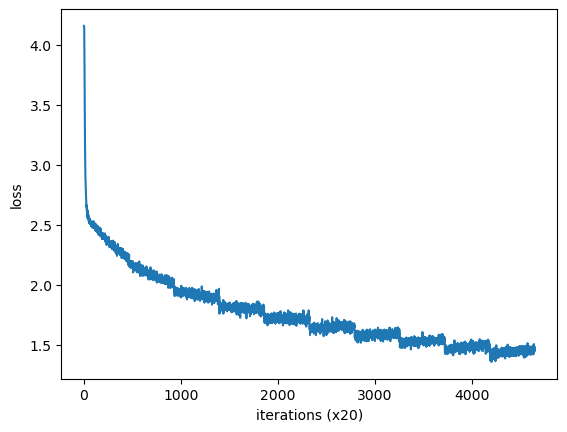

In [14]:
# Learning of CBOW
GPU = False

import sys
# sys.path.append("../org/deep-learning-from-scratch-2/")

# #check if there is common directory in the path
# print(sys.path)
import os
sys.path.append(os.path.abspath("../.org/deep-learning-from-scratch-2/"))


import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

# Hyper parameters
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# Load corpus
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if GPU:
    contexts = to_gpu(contexts)
    target = to_gpu(target)

# Create model
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# Training
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# save data
word_vecs = model.word_vecs
if GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)


### 4.3.3 Testing of CBOW model

In [6]:
import sys
sys.path.append("./.org/deep-learning-from-scratch-2/")

from common.util import most_similar, analogy

In [7]:
import sys
sys.path.append("./.org/deep-learning-from-scratch-2/")
from common.util import most_similar
import pickle


pkl_file = './notebook/cbow_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.74169921875
 i: 0.693359375
 your: 0.650390625
 they: 0.6220703125
 anybody: 0.59716796875

[query] year
 month: 0.837890625
 week: 0.7529296875
 spring: 0.7373046875
 summer: 0.72216796875
 decade: 0.7080078125

[query] car
 luxury: 0.65234375
 auto: 0.6337890625
 truck: 0.623046875
 cars: 0.61328125
 window: 0.60107421875

[query] toyota
 nissan: 0.6455078125
 honda: 0.630859375
 nec: 0.6171875
 weyerhaeuser: 0.611328125
 steel: 0.60888671875


In [21]:
from common.util import cos_similarity

print(word_to_id["you"])
print(word_vecs[(word_to_id["you"]),:])

print(word_to_id["i"])
print(word_vecs[(word_to_id["i"]),:])

cos_similarity(word_vecs[(word_to_id["you"]),:], word_vecs[(word_to_id["year"]),:])

316
[-0.5312   0.4575  -1.173   -1.28     2.566   -0.1176  -0.324   -0.269
 -2.074    1.507    0.2262  -1.129    0.1704  -0.4583  -0.3774   1.527
 -2.213    0.0639  -0.812   -0.1112   0.386    0.3208  -0.9717   0.1511
 -1.515    0.2491  -0.375    0.4612  -1.104    0.684    0.622   -0.77
  0.294   -0.805    0.3657  -0.4216  -1.184   -0.666    0.1037   0.6797
  0.6895  -1.915    1.022   -0.3389  -0.814   -0.5713  -0.9165  -0.8345
  1.343   -0.388   -0.5684  -1.778   -1.201    1.59    -0.946   -0.1375
 -0.1006   0.04816  0.2484  -0.3464  -0.06714 -0.4504  -1.788   -0.463
  0.433   -0.6426  -0.61    -0.708    1.022    1.032   -0.2015   0.9614
 -0.1702   0.1406  -0.9517   0.435   -0.6533   1.687   -0.8154   0.2673
  1.111    0.846   -1.219    0.6772  -0.8057  -0.5903   1.975    0.766
  0.04108 -0.2426   0.719   -0.1978  -1.496   -0.911   -0.4246   0.9336
  0.0717   0.0498   0.9136   0.2974 ]
1040
[-0.1798    0.6133   -0.2764    0.3784    1.514     0.08044  -1.621
 -1.2295   -0.541     0.848

0.02425

In [23]:
from common.util import analogy

analogy('man', 'king', 'woman', word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go', word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child', word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad', word_to_id, id_to_word, word_vecs)


[analogy] man:king = woman:?
 horse: 3.876953125
 ton: 3.876953125
 weisfield: 3.826171875
 hat: 3.732421875
 award: 3.638671875

[analogy] take:took = go:?
 eurodollars: 5.53125
 a.m: 4.54296875
 went: 4.21875
 came: 4.21484375
 're: 4.1875

[analogy] car:cars = child:?
 a.m: 6.37890625
 children: 5.171875
 rape: 5.0
 incest: 4.8046875
 bond-equivalent: 4.6953125

[analogy] good:better = bad:?
 less: 5.75
 more: 5.6640625
 rather: 5.26953125
 greater: 4.53125
 worse: 4.03515625


## 4.4 Remained theme of CBOW

### 4.4.1 Application sample of word2vec

trained model of word2vec can be used to solve the analogy problem.
単語を固定長ベクトルに変換することで自然言語の様々なタスク(感情分析など)に使用することができる。

### 4.4.2 Evaluation method of word vector

実際のアプリケーションでは複数のシステムを組み合わせて作られる。

- 単語の分散表現の作成
- 特定の問題に対して分類を行う

2段階の機械学習を同時にチューニングするには多くの時間がかかるため、
分散表現の良さをアプリケーションと切り離して評価するのが一般的である。

